In [4]:
import os
import cv2
import pytesseract
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def display_image(image, figsize=(15,10)):
    try:
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except: 
        pass
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.imshow(image, cmap='gray')

In [6]:
from table_extractor import TableExtractor
te = TableExtractor()

In [9]:
image = cv2.imread('Images/table1.png')
image.shape

(975, 1443, 3)

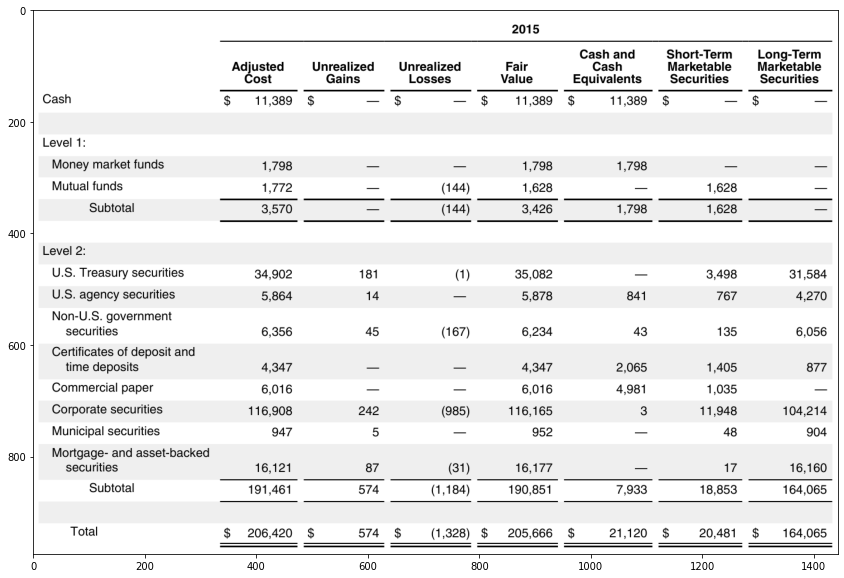

In [10]:
display_image(image)

In [6]:
def remove_hor_lines(image):
    gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Remove horizontal lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,1))
    detected_lines = cv2.morphologyEx(threshold_image, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        contour_image = cv2.drawContours(image, [c], -1, (255,255,255), 2)
    try:
        return contour_image
    except:
        return image

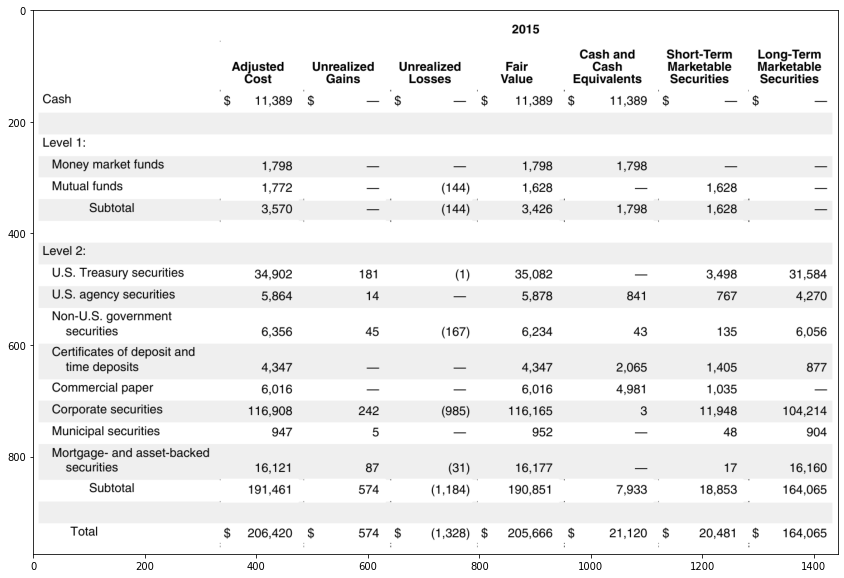

In [7]:
image = remove_hor_lines(image)
display_image(image)

In [8]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
threshold_image = cv2.threshold(gray_image, 250, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
threshold_image.shape

(975, 1443)

In [9]:
def find_contours(threshold_image):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(5, 5))
    dilated_image = cv2.dilate(threshold_image, kernel, anchor=(-1, -1), iterations=1)
    contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [10]:
contours = find_contours(~threshold_image)

In [11]:
def draw_contours(contours, img_shape):
    contour_image = np.zeros(img_shape, dtype=np.uint8)
    contour_boxes = []

    for contour in contours:
        box = cv2.boundingRect(contour)
        x,y,w,h = box
        contour_image = cv2.rectangle(contour_image, (x,y), (x+w, y+h), (255), -1)

    return contour_image

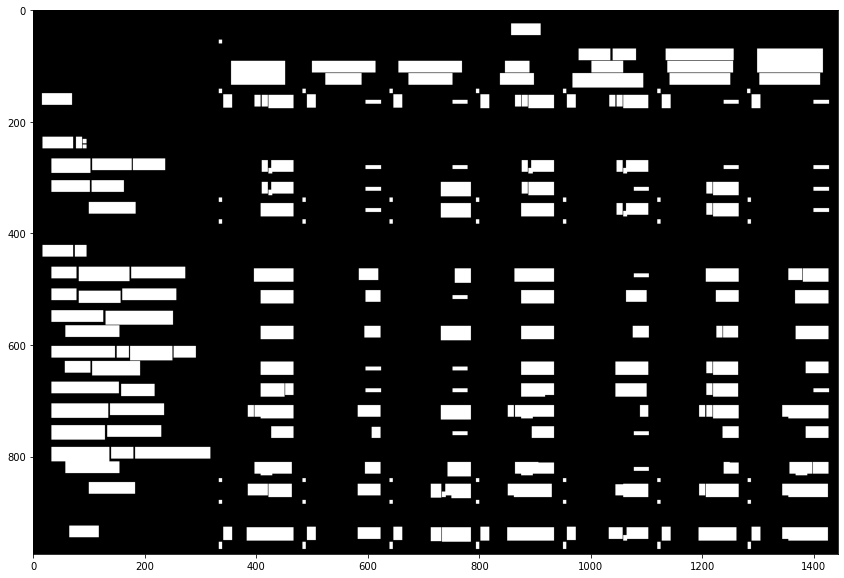

In [12]:
contour_image = draw_contours(contours, gray_image.shape)
display_image(contour_image)

In [13]:
def find_contours_on_contours(contour_image):
    threshold_image = cv2.threshold(contour_image, 250, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(8, 8))
    open_image = cv2.morphologyEx(threshold_image, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(open_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours
    
def remove_noise(contours, minContourArea=100):
    ''' 
    Removing NOISE by removing contours with area less than minContourArea 
    '''
    contours = [c for c in contours if cv2.contourArea(c) > minContourArea]
    return contours

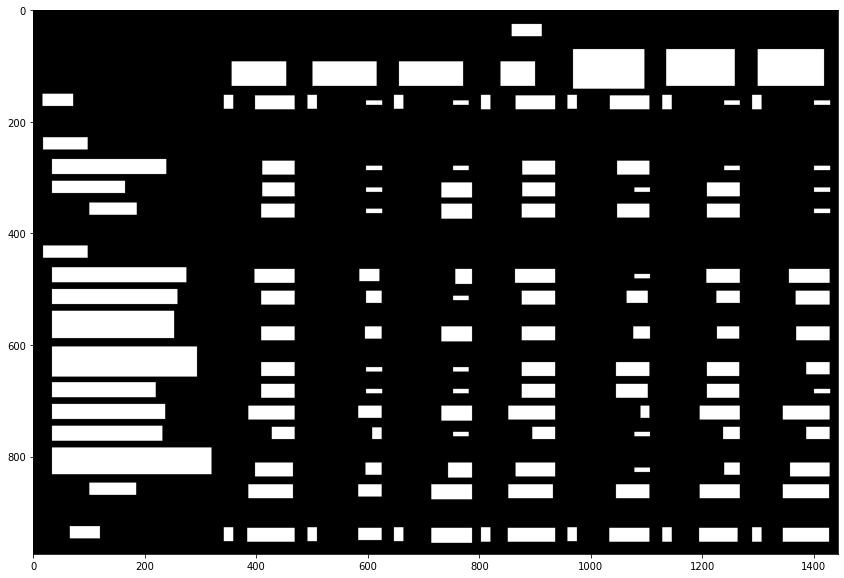

In [16]:
contours = find_contours_on_contours(contour_image)
contours = remove_noise(contours)
ctr_image = draw_contours(contours, gray_image.shape)
display_image(ctr_image)

In [14]:
def get_bounding_boxes(contours, min_text_height_limit = 10):
    contour_boxes = []
    for contour in contours:
        box = cv2.boundingRect(contour)
        h = box[3]

        if min_text_height_limit < h:
            contour_boxes.append(box)
    return contour_boxes

In [15]:
contour_boxes = get_bounding_boxes(contours)
len(contour_boxes)

113

In [16]:
# # find the contours on the mask (with solid drawn shapes) and draw outline on input image
# ctr_image = np.zeros(image.shape, dtype=np.uint8)
# countours,hierarchy=cv2.findContours(contour_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# for contour in contours:
#     box = cv2.boundingRect(contour)
#     x,y,w,h = box
#     ctr_image = cv2.rectangle(ctr_image, (x,y), (x+w, y+h), (255,255,255), -1)
# display_image(ctr_image)

In [17]:
def _group_cells_by_row(cells: list):
    cell_rows = []
    while cells:
        first = cells[0]
        rest = cells[1:]
        row = [c for c in rest if _cells_in_same_row(c, first)]
        row = sorted([first] + row, key=lambda c: c[0])
        cell_rows.append(row)
        cells = list(set(rest) - set(row))

    cell_rows = sorted(cell_rows, key=lambda x: x[0][1])
    return cell_rows

def _cells_in_same_row(c1, c2):
    c1_center = c1[1] + c1[3] - c1[3] / 2
    c2_top = c2[1]
    c2_bottom = c2[1] + c2[3]
    return c2_top < c1_center < c2_bottom

In [21]:
    def _group_cells_by_col(cells: list):
        columns = []
        cells = sorted(contour_boxes, key=lambda x:x[1])
        cells = sorted(contour_boxes, key=lambda x:x[0])
        while cells:
            first = cells[0]
            rest = cells[1:]
            cols = [c for c in rest if _cells_in_same_col(first, c)]
            cols = sorted([first] + cols, key=lambda c: c[1])
            columns.append(cols)
            cells = list(set(rest) - set(cols))

        columns = sorted(columns, key=lambda x: x[0][0])
        return columns

    def _cells_in_same_col(c1, c2):
        c1_left = c1[0]
        c1_right = c1[0] + c1[2]
        c2_left = c2[0] 
        c2_right = c2[0] + c2[2]
        return (c1_left <= c2_left <= c1_right) or (c2_left <= c1_left <= c2_right)

In [22]:
cell_rows = _group_cells_by_row(contour_boxes)
columns = _group_cells_by_col(contour_boxes)

In [23]:
len(columns)

16

##### Find lines to separate rows

In [37]:
bottom = [max([y+h for (x,y,w,h) in row]) for row in cell_rows]
top = [min([y for (x,y,w,h) in row]) for row in cell_rows][1:]

first = [5]
last = [image.shape[0] - 5]
# Finding the center horizontally to draw the lines
hor_lines = first + [b + int((a-b)/2) for a,b in zip(top, bottom)] + last

hor_lines

[5,
 58,
 145,
 202,
 258,
 300,
 340,
 397,
 452,
 495,
 533,
 577,
 598,
 644,
 661,
 700,
 740,
 777,
 821,
 842,
 900,
 970]

##### Find lines to separate columns

In [38]:
right = [max([x+w for (x,y,w,h) in col]) for col in columns]
left = [min([x for (x,y,w,h) in col]) for col in columns][1:]

first = [5]
last = [image.shape[1] - 5]
# Finding the center vertically to draw the lines
ver_lines = first + [b + int((a-b)/2) for a,b in zip(left, right)] + last

ver_lines

[5,
 210,
 263,
 357,
 480,
 505,
 635,
 660,
 794,
 828,
 946,
 971,
 1116,
 1140,
 1277,
 1302,
 1438]

#### Remove lines that are overlaping text

In [39]:
def remove_overlaping_lines(hor_lines, ver_lines, rows, columns):
        rows_x = []
        cols_y = []

        for row in rows:
            for (x,y,w,h) in row:
                rows_x.extend(list(range(x, x+w)))

        for col in cols:
            for (x,y,w,h) in col:
                cols_y.extend(list(range(y, y+h)))

        new_ver_lines = list(set(ver_lines) - set(rows_x))
        new_hor_lines = list(set(hor_lines) - set(cols_y))

        return new_hor_lines, new_ver_lines

In [40]:
hor_lines, ver_lines = remove_overlaping_ines(hor_lines, ver_lines, cell_rows, columns)

In [45]:
def draw_lines(image):
    
    final_image = image.copy()

    x1 = 0
    x2 = image.shape[1]

    y1 = 0
    y2 = image.shape[0]

    for i in hor_lines:
        y = int(i)
        final_image = cv2.line(final_image, (x1,y), (x2, y), (255,0,0), 1)

    for j in ver_lines:
        x = int(j)
        final_image = cv2.line(final_image, (x,y1), (x,y2), (255,0,0), 1)
        
    return final_image

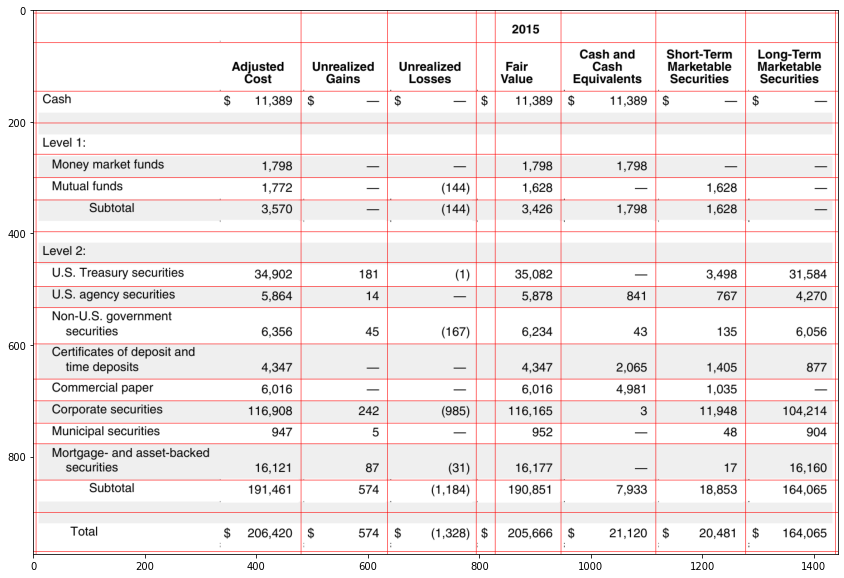

In [46]:
final_image = draw_lines(image)
display_image(final_image)

In [42]:
cv2.imwrite('out_grid.png', final_image)

True